<a href="https://colab.research.google.com/github/Glifoyle/test-repo/blob/master/4_MLP_v5_PyTorch_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 目的：ニューラルネットワークの「学習」を画像データに適用する

### 概要：全結合型ニューラルネットワークMLP（Multi-Layer Perceptron：多層パーセプトロン）の学習により，MNISTの手書き文字画像を分類する

<br>
&copy; 2021-2024 Hiro Kimura
<br>

## ポイント：

-  データには，**MNIST**(Modified National Institute of Standards and Technology)の，数字0から9の手書き文字のデータセットを用いる
-  学習モデルには，**MLP**（Multi-Layer Perceptron）モデルを用いる
-  PyTorchフレームワークの機能（自動微分等）を用いる
-  損失関数には正解ラベルと予測値との**交差エントロピー誤差**を用いる
-  最適値の探索には，勾配降下法（**SGD**：確率的勾配降下法）を用いる



# 実習の準備

1. タイムゾーンを東京に変更する
1. Google Driveをマウントする
1. 作業ディレクトリ（フォルダ）を作成する
1. PyTorchフレームワークやライブラリを導入する



In [ ]:
# pythonのバージョン確認
# ! python --version

## タイムゾーンを東京に変更する

In [ ]:
# 現在の設定を確認
!date

Mon Apr 15 05:16:39 AM UTC 2024


In [ ]:
# 設定を変更
!rm /etc/localtime
!ln -s /usr/share/zoneinfo/Asia/Tokyo /etc/localtime

!date

Mon Apr 15 02:16:40 PM JST 2024


## Google Driveをマウントする

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 作業フォルダ（作業ディレクトリ）を作成
import os

chap_dir = "/content/drive/MyDrive/practice/chap_mnist"
if not os.path.exists(chap_dir): # ディレクトリが存在していなければ
    # os.mkdir(chap_dir)
    os.makedirs(chap_dir) # ディレクトリを，途中のディレクトリも含めて，作成する

os.chdir(chap_dir) # 今回の作業ディレクトリに移動する
os.getcwd() # 現在の作業ディレクトリを表示する

'/content/drive/MyDrive/practice/chap_mnist'

## PyTorchのインストール

- デフォルトで導入されている

In [ ]:
# torch, torchvisionをインストール

# ! pip install torch==1.9.0 torchvision # verified version
# ! pip install torch torchvision # may be 1.10.0+cu111

# 「学習」の手順
1. データを準備する
  - データの読み込み
  - データの前処理
  - データの分割
  - データローダの作成
1. モデルを定義する
1. モデルを訓練する
  - 損失関数と最適化手法を設定
  - 訓練を実施
1. 学習済みモデルを性能評価する

# データを準備する


### MNISTデータセット
-  MNISTは$0～9$の手書き文字データ
-  正解ラベルは 0～9 の10クラス（種類）
-  6万枚の訓練用データ（画像と正解ラベル）
-  1万枚のテスト用データ（画像と正解ラベル）
-  画像は8ビットグレースケール（0：白～255：黒）
-  画像は幅：28 x 高さ：28ピクセル（784ピクセル）

<!-- <参考>　PyTorch公式サンプルコード<br>
https://github.com/pytorch/examples/blob/master/mnist/main.py -->


## データの読み込み（ネットワークから）
- データを読み込み，マウントしたgoogle drive 内に保存する
- データのダウンロードには，サーバやネットワークの負荷状況により，**数分程度**の時間がかかることがある

In [ ]:
# データを格納するディレクトリを作成する

data_dir = "./dataset"
if not os.path.exists(data_dir): # ディレクトリが存在していなければ
    os.makedirs(data_dir) # ディレクトリを，途中のディレクトリも含めて，作成する

# 現在の作業ディレクトリを確認する
!pwd
!ls -F

/content/drive/MyDrive/practice/chap_mnist
dataset/


## データの前処理

- データのダウンロード
  - 元のデータが訓練用とテスト用に分割されているので，別々にダウンロードする
    - trainval: 訓練用
    - test:     テスト用

- データダウンロード後に，自動的にデータの前処理も行う
  - Tensor型への変換
    - 画素値データ（0～255）をTensor型データに変換する
  - 標準化処理　平均値0.1307，標準偏差 0.3081
    - 最終的なTensor型データは，概ね-1.0～1.0 の範囲



In [ ]:
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
import os

# データをダウンロードし，Tensorに変換し，平均 0.1307，標準偏差 0.3081 で標準化する

# データの前処理の定義
# transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
transform=transforms.Compose([transforms.ToTensor(), ]) # Tensor変換だけ

# データのダウンロードと前処理
mnist_trainval = MNIST(root='./dataset', train=True, download=True, transform=transform)
mnist_test = MNIST(root='./dataset', train=False, download=True, transform=transform)

# # データのダウンロード済の場合は前処理だけ
# mnist_trainval = MNIST(root='./dataset', train=True, download=False, transform=transform)
# mnist_test = MNIST(root='./dataset', train=False, download=False, transform=transform)


In [ ]:
# フォルダ内を確認する --> MNISTフォルダが作成されている
!ls -l './dataset'

total 4
drwx------ 3 root root 4096 Apr 15 14:00 MNIST


In [ ]:
# データセットのタイプを確認する
print(type(mnist_trainval))
print(type(mnist_test))

# データセットの長さを確認する
# 訓練データ数：60,000件，テストデータ数：10,000件
print(len(mnist_trainval))
print(len(mnist_test))

<class 'torchvision.datasets.mnist.MNIST'>
<class 'torchvision.datasets.mnist.MNIST'>
60000
10000


### 画像を表示して確認する
- 画像データはテンソル型に変換済み

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# データの内容を確認する
# x_0 は最初の画像データ，t_0 は最初の教師ラベル（答えの数値）
# 1枚の画像（手書きの数字）は 28 x 28 ピクセルで構成されている
x_0, t_0 = mnist_trainval[0] # trainvalの最初の画像

# 画像データの型とサイズを確認する
print(type(x_0))  # Tensor型
print(x_0.size()) # Channel（色数）, Hight（縦）,Width（横）
img = x_0.reshape(28, 28) # 縦 x 横 : 28 ピクセル x 28 ピクセル

# 正解ラベルを表示する
print('正解ラベル：{}'.format(t_0))

<class 'torch.Tensor'>
torch.Size([1, 28, 28])
正解ラベル：5


In [ ]:
# 画像データの値を見てみる

print(x_0.size())
print(x_0)

torch.Size([1, 28, 28])
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000,

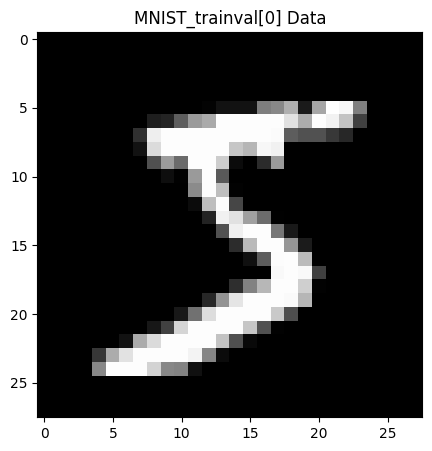

正解ラベル：5


In [ ]:
# 画像を表示する
# 図の大きさをインチ単位で指定する
plt.figure(figsize=(5,5))

plt.title("MNIST_trainval[0] Data") # trainvalの最初の画像

# 画像を白黒で表示する
plt.imshow(img, cmap='gray')
# plt.imshow(img, cmap='binary')

plt.show()
print(f"正解ラベル：{t_0}")

In [ ]:
# # 画像をファイルに出力する
# from PIL import Image

# # 画像を0から255の範囲に変換する
# img = img * 255

# # 画像をPillow Imageオブジェクトに変換する
# pil_img = Image.fromarray(img.numpy().astype('uint8'))

# # 画像をファイルに出力する
# pil_img.save('./mnist_0.png')

## データの分割
- 通常は，訓練用，検証用，テスト用に**3分割**する（最低でも，訓練用，テスト用に**2分割**にする（下記<注意>を参照））
  - 訓練用 = 55,000枚
  - 検証用 = 5,000枚（訓練データ 60,000枚の内の5,000枚），訓練状況の検証用
  - テスト用 = 10,000枚，モデル性能のテスト用
- 検証用は，訓練が**過学習になってないか**，訓練状況の確認に使用
- テスト用は，学習済みモデルの**性能を確認**するために使用<br>

**<注意>**<br>
**（カンニング禁止）**：一度でも訓練で使用したデータはテストに使ってはいけない

In [ ]:
# ライブラリ
import torch

# 乱数シードを固定して再現性を確保する
torch.manual_seed(24)

In [ ]:
from torch.utils.data import random_split

# 訓練データを，train (55,000 images), val (5,000 images)に分割
# 訓練：train，検証：val stands for validation
mnist_train, mnist_val = random_split(mnist_trainval, [55000, 5000])

In [ ]:
# データセットの長さを確認する
# train: 55,000, val: 5,000, test: 10,000
print(len(mnist_train))
print(len(mnist_val))
print(len(mnist_test))

55000
5000
10000


## データローダの作成
- データローダとは，指定したミニバッチ数のデータを提供してくれるもの
  - データは，（データと教師ラベルの組）x ミニバッチ数 で構成される
  - shuffle=True を指定：ランダムにミニバッチ数のデータを選択して提供してくれる
  - shuffle=False を指定：毎回同じ順番でデータを提供してくれる



In [ ]:
from torch.utils.data import DataLoader

# The dataloaders handle shuffling, batching, etc...
# ミニバッチ長を100とする（100枚の画像毎に訓練する）
b_size = 100

# 3つのデータローダを作成する
mnist_train_loader = DataLoader(mnist_train, batch_size=b_size, shuffle=True)
mnist_val_loader = DataLoader(mnist_val, batch_size=b_size, shuffle=False)
mnist_test_loader = DataLoader(mnist_test, batch_size=b_size, shuffle=False)

# モデルを定義する


- 説明変数（入力）は，768個（28 x 28）
- 目的変数（出力）は，10個（10種類の数値（0～9）のクラス分類確率）
- ニューラルネットワークモデル（入力層768個，出力層10個，隠れ層1層）
- 活性化関数は，ReLU


## MLPモデル
- 入力784個：画素値
- 出力10個：分類する数字の種類，クラス数
- 隠れ層（中間層）一層，層数・ノード数とも自由に設計できる
- 活性化関数
  - ReLU
  - 最終出力は，対数ソフトマックス関数

In [ ]:
# -----------------
# 3L-MLP
# -----------------
import torch
from torch import nn
import torch.nn.functional as F

class MNISTClassifier_MLP(nn.Module):

  def __init__(self):
    super(MNISTClassifier_MLP, self).__init__()

    # mnist images have (1, 28, 28) of shape : (channels, width, height)
    self.layer_1 = nn.Linear(28 * 28, 128)  # 入力：784，入力層出力：128
    self.layer_2 = nn.Linear(128, 256)      # 中間層入力：128，中間層出力：256
    self.layer_3 = nn.Linear(256, 10)       # 出力層入力：256，出力：10

  def forward(self, x):
    # 入力はバッチサイズ分の画像データ
    batch_size, channels, width, height = x.size()

    # b: batch（バッチ長）, c: channel（カラー数）, w: width（横）, h: height（縦）
    # (b, c, w, h) = (100, 1, 28, 28) -> (100, 1*28*28)
    x = x.view(batch_size, -1) # (100, 768)

    # layer 1
    x = self.layer_1(x)
    x = F.relu(x)

    # layer 2
    x = self.layer_2(x)
    x = F.relu(x)

    # layer 3
    x = self.layer_3(x)

    # probability distribution over labels => log_softmax()
    x = F.log_softmax(x, dim=1)
    # x = F.softmax(x, dim=1)

    return x

# モデルを訓練する
## 損失関数と最適化手法を設定する
- 損失関数：分類問題なので，交差エントロピー誤差（$loss=-\sum_{k}^{n} t_{k}\log y_k$）
- 最適化手法：ここでは，SGDを選択

### 損失関数（交差エントロピー誤差）
- 教師ラベル$t$は **one-hotベクトル**（一つの要素だけが1で，他の要素は全て0のベクトル）で表現する<br>
例えば，$5$であれば，0から始まるので6番目の要素だけが1で，$$t = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]$$<br>
- 予測結果 $y$ は，softmax関数を施した$0～1$の実数値を要素とするベクトルで表現する<br>
softmax関数を施した出力の合計は$1$になる（つまり各要素は確率とみなすことができる）<br>
例えば，$$y = [0.01, 0.0, 0.08, 0.02, 0.0, 0.6, 0.18, 0.04, 0.02, 0.05]$$
- 損失関数には交差エントロピー誤差を用いる<br>
$$ loss = -\sum_{n=1}^n t_n\log y_n $$
ここで，$log$は自然対数を表す．交差エントロピー誤差は，結果的に $t$ が1の要素の自然対数値だけになる．
例えば，上記の場合には，教師ラベルが$1$の6番目の項だけが残るので，$ -1*\log 0.6 = 0.51$ と計算できる



In [ ]:
# 学習モデルの初期化

model = MNISTClassifier_MLP() # モデルパラメータ値の初期化
# model = model.to(device) # モデルのパラメータ値を演算デバイスに送る

In [ ]:
# 損失関数（交差エントロピー誤差）
import torch.nn as nn

criterion = nn.CrossEntropyLoss()

In [ ]:
# 最適化手法（SGD）
from torch import optim

# 学習率 lr は試行錯誤する必要がある．
eta = 0.01
optimizer = optim.SGD(model.parameters(), lr=eta) # SGD

## 訓練と検証用の関数

- 作業フォルダに **train_valid.py** が存在することを確認する
    - 存在しない場合は，以下のセルを実行してアップロードする
    - またはファイルアイコンから作業ディレクトリを開いて、パソコンからドラッグ&ドロップする


In [ ]:
from google.colab import files

uploaded = files.upload()

In [ ]:
# 作業フォルダを確認する
!ls -F

dataset/  train_valid.py


In [ ]:
# 関数を読み込む
from train_valid import train, valid

# # 訓練用の関数（1エポックの処理）を定義
# def train(model, criterion, optimizer, train_loader, device, scheduler=None):
#       return epoch_loss, epoch_acc # 1エポックの1データ当たりのロスと正解率

# # 検証用の関数（1エポックの処理）を定義
# def valid(model, criterion, optimizer, valtest_loader, device):
#       return val_loss, val_acc # 1エポックの1データ当たりのロスと正解率


## 訓練を実施する

- 20エポック：train: 55,000 件 x 20 回 の学習
- 訓練時間：CPUで 18秒/epoch 程度（20 epochでは360秒 = 6分程度）かかる

In [ ]:
# 演算装置
device = "cpu"

In [ ]:
# 訓練を実施する

# 訓練の長さ
EPOCHS=20
# 提出課題では，上の行をコメントにして，下の行のコメントを外して実行する
# EPOCHS=40

# 訓練と検証の状況を記録する空の入れ物
train_loss_list = [] # 訓練ロス
train_acc_list = [] # 訓練の正解率
val_loss_list = [] # 検証ロス
val_acc_list = [] # 検証の正解率

for epoch in range(EPOCHS):
    # エポックの処理
    # 訓練
    loss, acc = train(model, criterion, optimizer, mnist_train_loader, device)

    # 検証
    val_loss, val_acc = valid(model, criterion, optimizer, mnist_val_loader, device)

    print('epoch %d, train_loss: %.2f train_acc: %.2f val_loss: %.2f val_acc: %.2f' % (epoch, loss, acc, val_loss, val_acc))

    # 訓練と検証の状況を記録
    train_loss_list.append(loss)
    train_acc_list.append(acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

epoch 0, train_loss: 2.05 train_acc: 0.49 val_loss: 1.45 val_acc: 0.69
epoch 1, train_loss: 0.90 train_acc: 0.78 val_loss: 0.62 val_acc: 0.83
epoch 2, train_loss: 0.52 train_acc: 0.86 val_loss: 0.45 val_acc: 0.87
epoch 3, train_loss: 0.41 train_acc: 0.89 val_loss: 0.38 val_acc: 0.89
epoch 4, train_loss: 0.37 train_acc: 0.90 val_loss: 0.35 val_acc: 0.90
epoch 5, train_loss: 0.34 train_acc: 0.90 val_loss: 0.33 val_acc: 0.90
epoch 6, train_loss: 0.32 train_acc: 0.91 val_loss: 0.31 val_acc: 0.91
epoch 7, train_loss: 0.30 train_acc: 0.91 val_loss: 0.30 val_acc: 0.91
epoch 8, train_loss: 0.29 train_acc: 0.92 val_loss: 0.28 val_acc: 0.91
epoch 9, train_loss: 0.28 train_acc: 0.92 val_loss: 0.27 val_acc: 0.92
epoch 10, train_loss: 0.27 train_acc: 0.92 val_loss: 0.26 val_acc: 0.92
epoch 11, train_loss: 0.26 train_acc: 0.92 val_loss: 0.26 val_acc: 0.92
epoch 12, train_loss: 0.25 train_acc: 0.93 val_loss: 0.25 val_acc: 0.93
epoch 13, train_loss: 0.24 train_acc: 0.93 val_loss: 0.24 val_acc: 0.93
ep

## 訓練の様子をグラフ表示

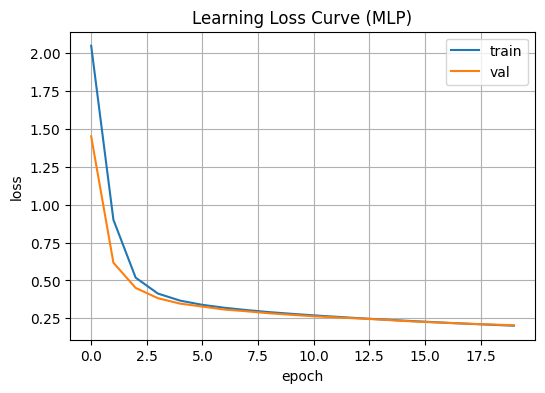

In [ ]:
# 損失が減少していく様子をグラフ表示する
%matplotlib inline
from matplotlib import pyplot as plt

# 図の大きさをインチ単位で指定する
plt.figure(figsize=(6, 4))

plt.title('Learning Loss Curve (MLP)') # タイトル
plt.plot(train_loss_list, label='train') # 訓練ロスグラフ
plt.plot(val_loss_list, label='val') # 検証ロスグラフ
plt.legend() # 凡例
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(axis="both") # グリッド表示

plt.show()

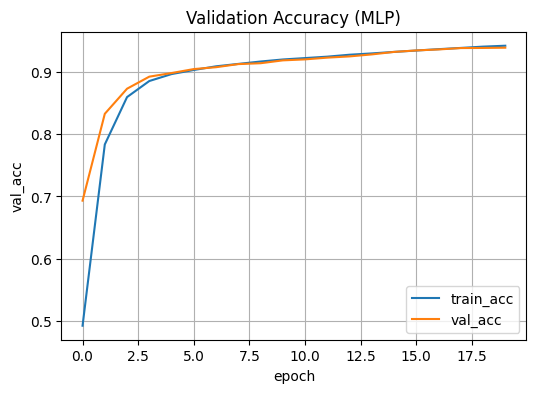

val正解率：0.939


In [ ]:
# 正解率が上昇していく様子をグラフ表示する

# 図の大きさをインチ単位で指定する
plt.figure(figsize=(6, 4))

plt.title('Validation Accuracy (MLP)') # タイトル
plt.plot(train_acc_list, label="train_acc")
plt.plot(val_acc_list, label='val_acc')
plt.legend() # 凡例
plt.xlabel('epoch')
plt.ylabel('val_acc')
plt.grid(axis="both") # グリッド表示

plt.show()
print(f'val正解率：{val_acc_list[-1]:.3f}')

## 訓練済みモデルを保存する


In [ ]:
# 現在の作業ディレクトリに訓練済みモデルのパラメータ値を保存する

torch.save(model.state_dict(), './mnist_mlp.pkl')

# 学習済みモデルを評価する

## テストデータでモデルの予測性能を評価する

In [ ]:
# テストを実施する

# テスト
test_loss, test_acc = valid(model, criterion, optimizer, mnist_test_loader, device)
print('test_loss: %.2f test_acc: %.2f' % (test_loss, test_acc))


test_loss: 0.20 test_acc: 0.94


# まとめ
MLP（Multi-Layer Perseptron）を用いた全結合型ニューラルネットワークモデルを構築し，MNIST画像の分類を行った．
- MLPモデルでMNIST画像が精度良く（97%程度の精度で）分類できることが理解できた
- 画像データに関しても，数値データと同様の「学習」の手続きが適用できることが理解できた
  1. データの準備
    1. データの前処理（標準化）
    1. データ分割
    1. データローダの作成
  1. モデルの定義
  1. モデルの訓練と検証
  1. 学習済みモデルの性能評価
- MLPモデルの構造と定義方法が理解できた
- モデルの訓練と検証，性能評価の方法が理解できた


# [提出課題]

- 以下の手順に従って，エボック数を40に増やしたときの，予測精度を確認する

  1. エポック数の指定を，以下のように修正する
    ```
    # 訓練の長さ
    # EPOCHS=20
    # 提出課題では，上の行をコメントにして，下の行のコメントを外して実行する
    EPOCHS=40
    ```
  1. 以下の手順でプログラムを再実行する
    1. メニューバーの，ランタイム ／ ランタイムを再起動
    1. メニューバーの，ランタイム ／ すべてのセルを実行

  1. テストデータでモデルの予測性能を評価する
    1. test_loss の値を小数第3位を四捨五入して小数第2位までで答えよ
    1. test_acc の値を小数第3位を四捨五入して小数第2位までで答えよ


<!--
1. MPLモデルの隠れ層（中間層）を128ノードから512ノードに変更して，精度が変わるか確認する

1. MLPモデルの最終段の出力層の活性化関数を変更して実行し，結果の違いをグラフで確認する
 - F.log_softmax(x, dim=1)
 - F.softmax(x, dim=1)
 - なし（コメントアウト）

1. breastcancer.xlsxを読み込んで，悪性と良性を分類する．分類性能をchap4のロジスティク回帰の結果と比較する
  - ファイルからデータを読み込んで，スケール変換し，データ分割し，データローダを作成するところまでは，chap4と同様にする
  - MLPモデルを修正する
    - 入力ノード数が，breastcancerの説明変数の数と同じ30個
    - 出力ノード数が，悪性と良性の2クラスなので2個
-->